<a href="https://colab.research.google.com/github/TYH71/Pneumonia-Classification-w-XAI/blob/main/notebook/Model_Training_(Pneumonia_Classification).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Classification

![Example Images](https://i.imgur.com/jZqpV51.png)

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

Source: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


In [ ]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# import misc libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import copy
from tqdm import tqdm

# import torch modules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import models 
from torchvision import transforms as T
from torchinfo import summary
print("torch:", torch.__version__)
print("torchvision:", torchvision.__version__)

torch: 1.12.0+cu113
torchvision: 0.13.0+cu113


In [ ]:
# monitor gpu devices
! nvidia-smi

# GPU configuration code
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

torch.backends.cudnn.benchmark = True

Sat Jul 16 14:09:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Mount GDrive Volume

At the current moment, the data is migrated to my Google Drive (Yu Hoe). Requires to mount to my drive volume in order to access the image dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset & DataLoader

Creating Dataset and DataLoader class. Augmentation has been applied.



In [ ]:
from torchvision.transforms.transforms import RandomRotation
# normalization config (different architectures have different normalization config)
norm_cfg = dict(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225],
)

# train data pipeline
# train_pipeline = T.Compose([
#     T.RandomResizedCrop(224),
#     T.RandomHorizontalFlip(),
#     T.ColorJitter(),
#     T.RandomApply([
#         T.RandomRotation(30)
#     ], p=0.5),
#     T.ToTensor(),
#     T.Normalize(**norm_cfg)
# ])

# train data pipeline
train_pipeline = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(), # randomly change the brightness, contrast, saturation and hue of an image
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize(**norm_cfg)
])

# val/test data pipeline
test_pipeline = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize(**norm_cfg)
])

In [ ]:
# set up directory path
dir = 'drive/MyDrive/Pneumonia Classification/chest_xray'
data_dir = {k : os.path.join(dir, k) for k in ['train', 'val', 'test']}

# load as Dataset class via torch's ImageFolder module
train_data = ImageFolder(data_dir['train'], transform=train_pipeline)
val_data = ImageFolder(data_dir['val'], transform=test_pipeline)
test_data = ImageFolder(data_dir['test'], transform=test_pipeline)

# validate that data is loaded - via .__str__() method of ImageFolder
print(train_data, val_data, test_data, sep='\n\n')

# prepare classes index
assert train_data.classes == val_data.classes == test_data.classes, "classes do not match"
class_names = train_data.classes

# dataset sizes
dataset_sizes = dict(
    train = len(train_data),
    val = len(val_data),
    test = len(test_data)
)

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: drive/MyDrive/Pneumonia Classification/chest_xray/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ColorJitter(brightness=None, contrast=None, saturation=None, hue=None)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

Dataset ImageFolder
    Number of datapoints: 624
    Root location: drive/MyDrive/Pneumonia Classification/chest_xray/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.40

In [ ]:
# building dataloader
dataloader_cfg = dict(
    batch_size = 32,
    num_workers = 2,
)

dataloaders = dict(
    train   = DataLoader(train_data, shuffle=True, pin_memory=True, **dataloader_cfg),
    val     = DataLoader(val_data, **dataloader_cfg),
    test    = DataLoader(test_data, **dataloader_cfg)
)

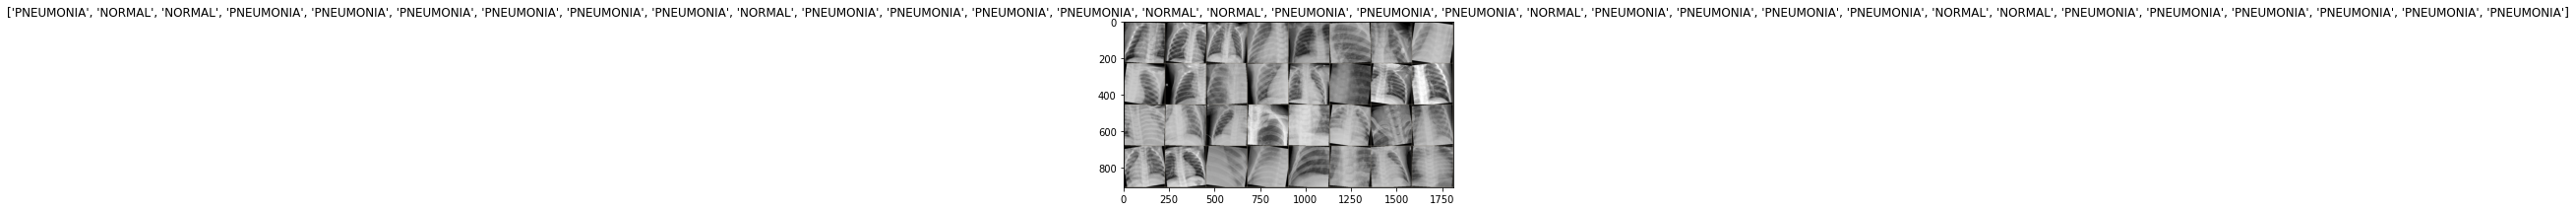

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Model Development

In [ ]:
model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss() # edited CE to BCE, since there are only two classes

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
# model summary
summary(model_ft, (dataloader_cfg['batch_size'], 3, 224, 224), depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 2]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          73,984
│    └─BasicBlock: 2-2                   [32, 64, 56, 56]          73,984
├─Sequential: 1-6                        [32, 128, 28, 28]         --
│    └─BasicBlock: 2-3                   [32, 128, 28, 28]         230,144
│    └─BasicBlock: 2-4                   [32, 128, 28, 28]         295,424
├─Sequential: 1-7                        [32, 256, 14, 14]         --
│    └─BasicBlock: 2-5                   [32, 256, 14, 14]     

# Model Training

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
%%time
# will save best model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


100%|██████████| 163/163 [01:12<00:00,  2.25it/s]


train Loss: 0.3623 Acc: 0.8480


100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


val Loss: 0.4547 Acc: 0.8157

Epoch 1/24
----------


100%|██████████| 163/163 [01:09<00:00,  2.35it/s]


train Loss: 0.2617 Acc: 0.8901


100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


val Loss: 0.3048 Acc: 0.8798

Epoch 2/24
----------


100%|██████████| 163/163 [01:11<00:00,  2.27it/s]


train Loss: 0.2439 Acc: 0.8990


100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


val Loss: 0.5376 Acc: 0.7772

Epoch 3/24
----------


100%|██████████| 163/163 [01:12<00:00,  2.26it/s]


train Loss: 0.2308 Acc: 0.9055


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


val Loss: 0.3120 Acc: 0.9006

Epoch 4/24
----------


100%|██████████| 163/163 [01:11<00:00,  2.27it/s]


train Loss: 0.2254 Acc: 0.9062


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


val Loss: 0.2851 Acc: 0.8990

Epoch 5/24
----------


100%|██████████| 163/163 [01:11<00:00,  2.28it/s]


train Loss: 0.2223 Acc: 0.9101


100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


val Loss: 0.5446 Acc: 0.7724

Epoch 6/24
----------


100%|██████████| 163/163 [01:11<00:00,  2.29it/s]


train Loss: 0.1931 Acc: 0.9254


100%|██████████| 20/20 [00:10<00:00,  1.99it/s]


val Loss: 0.5231 Acc: 0.7308

Epoch 7/24
----------


100%|██████████| 163/163 [01:11<00:00,  2.28it/s]


train Loss: 0.1826 Acc: 0.9283


100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


val Loss: 0.2773 Acc: 0.9295

Epoch 8/24
----------


100%|██████████| 163/163 [01:13<00:00,  2.22it/s]


train Loss: 0.1587 Acc: 0.9388


100%|██████████| 20/20 [00:09<00:00,  2.03it/s]


val Loss: 0.2083 Acc: 0.9359

Epoch 9/24
----------


100%|██████████| 163/163 [01:10<00:00,  2.31it/s]


train Loss: 0.1594 Acc: 0.9367


100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


val Loss: 0.1991 Acc: 0.9407

Epoch 10/24
----------


100%|██████████| 163/163 [01:10<00:00,  2.31it/s]


train Loss: 0.1447 Acc: 0.9436


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


val Loss: 0.2420 Acc: 0.9343

Epoch 11/24
----------


100%|██████████| 163/163 [01:11<00:00,  2.27it/s]


train Loss: 0.1574 Acc: 0.9402


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


val Loss: 0.2773 Acc: 0.9231

Epoch 12/24
----------


100%|██████████| 163/163 [01:11<00:00,  2.29it/s]


train Loss: 0.1467 Acc: 0.9479


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


val Loss: 0.1650 Acc: 0.9487

Epoch 13/24
----------


100%|██████████| 163/163 [01:12<00:00,  2.25it/s]


train Loss: 0.1358 Acc: 0.9459


100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


val Loss: 0.2406 Acc: 0.9359

Epoch 14/24
----------


100%|██████████| 163/163 [01:12<00:00,  2.26it/s]


train Loss: 0.1285 Acc: 0.9546


100%|██████████| 20/20 [00:09<00:00,  2.01it/s]


val Loss: 0.2310 Acc: 0.9343

Epoch 15/24
----------


100%|██████████| 163/163 [01:11<00:00,  2.28it/s]


train Loss: 0.1291 Acc: 0.9540


100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


val Loss: 0.2265 Acc: 0.9375

Epoch 16/24
----------


100%|██████████| 163/163 [01:11<00:00,  2.27it/s]


train Loss: 0.1367 Acc: 0.9484


100%|██████████| 20/20 [00:09<00:00,  2.00it/s]


val Loss: 0.2057 Acc: 0.9407

Epoch 17/24
----------


100%|██████████| 163/163 [01:10<00:00,  2.30it/s]


train Loss: 0.1277 Acc: 0.9507


100%|██████████| 20/20 [00:11<00:00,  1.72it/s]


val Loss: 0.2071 Acc: 0.9375

Epoch 18/24
----------


100%|██████████| 163/163 [01:11<00:00,  2.28it/s]


train Loss: 0.1244 Acc: 0.9517


100%|██████████| 20/20 [00:10<00:00,  1.96it/s]


val Loss: 0.2352 Acc: 0.9359

Epoch 19/24
----------


100%|██████████| 163/163 [01:17<00:00,  2.10it/s]


train Loss: 0.1258 Acc: 0.9511


100%|██████████| 20/20 [00:12<00:00,  1.58it/s]


val Loss: 0.2617 Acc: 0.9311

Epoch 20/24
----------


100%|██████████| 163/163 [01:11<00:00,  2.27it/s]


train Loss: 0.1240 Acc: 0.9528


100%|██████████| 20/20 [00:09<00:00,  2.02it/s]


val Loss: 0.2122 Acc: 0.9407

Epoch 21/24
----------


100%|██████████| 163/163 [01:19<00:00,  2.05it/s]


train Loss: 0.1294 Acc: 0.9502


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


val Loss: 0.2203 Acc: 0.9423

Epoch 22/24
----------


100%|██████████| 163/163 [01:12<00:00,  2.24it/s]


train Loss: 0.1283 Acc: 0.9492


100%|██████████| 20/20 [00:09<00:00,  2.05it/s]


val Loss: 0.2586 Acc: 0.9327

Epoch 23/24
----------


100%|██████████| 163/163 [01:11<00:00,  2.28it/s]


train Loss: 0.1275 Acc: 0.9509


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]


val Loss: 0.2199 Acc: 0.9407

Epoch 24/24
----------


100%|██████████| 163/163 [01:11<00:00,  2.26it/s]


train Loss: 0.1299 Acc: 0.9532


100%|██████████| 20/20 [00:09<00:00,  2.04it/s]

val Loss: 0.2162 Acc: 0.9423

Training complete in 34m 22s
Best val Acc: 0.948718
CPU times: user 3min 28s, sys: 29.9 s, total: 3min 58s
Wall time: 34min 22s


## Saving Model Weights

In [ ]:
PATH = 'drive/MyDrive/Pneumonia Classification/best_weights.pth'
torch.save(model_ft.to('cpu').state_dict(), PATH)

## Loaded Model

In [ ]:
# reproducible code to intialise model
def load_model(weights_path):
    model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    num_ftrs = model_ft.fc.in_features
    # Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
    model_ft.fc = nn.Linear(num_ftrs, 2)
    model_ft.load_state_dict(torch.load(weights_path))
    return model_ft

loaded_model = load_model(PATH)
summary(loaded_model, [1, 3, 224, 224], depth=2)

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 2]                    --
├─Conv2d: 1-1                            [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]         128
├─ReLU: 1-3                              [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        [1, 64, 56, 56]           --
│    └─BasicBlock: 2-1                   [1, 64, 56, 56]           73,984
│    └─BasicBlock: 2-2                   [1, 64, 56, 56]           73,984
├─Sequential: 1-6                        [1, 128, 28, 28]          --
│    └─BasicBlock: 2-3                   [1, 128, 28, 28]          230,144
│    └─BasicBlock: 2-4                   [1, 128, 28, 28]          295,424
├─Sequential: 1-7                        [1, 256, 14, 14]          --
│    └─BasicBlock: 2-5                   [1, 256, 14, 14]      

In [ ]:
loaded_model.eval().to('cpu') # set model to evaluation mode

sample_batch, sample_classes = next(iter(dataloaders['test']))

pred = loaded_model(sample_batch)
argmax_pred = torch.argmax(pred, axis=1)
argmax_pred

tensor([0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


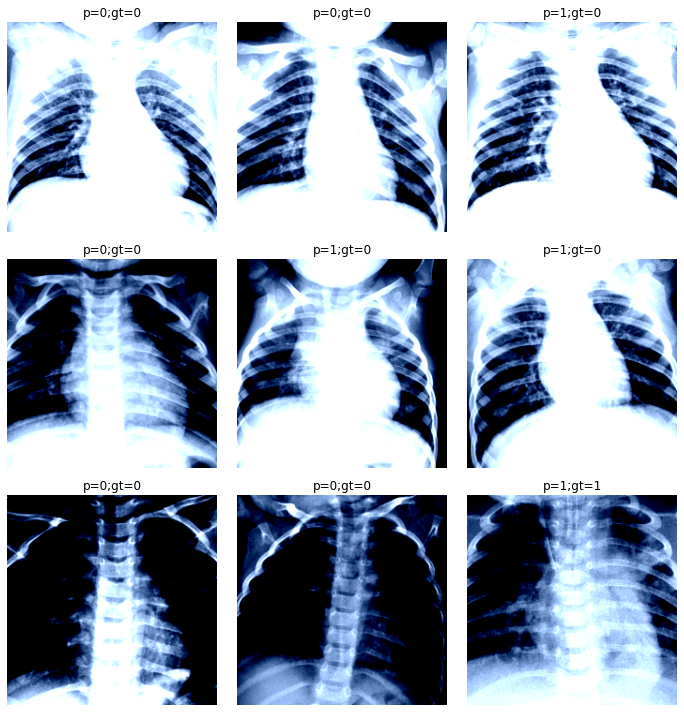

In [ ]:
fig = plt.figure(tight_layout=True, figsize=(10, 10))
for idx in range(9):
    ax = fig.add_subplot(3, 3, idx+1)
    ax.imshow(sample_batch[idx].permute((1, 2, 0)))
    ax.set_title("p={};gt={}".format(argmax_pred[idx], sample_classes[idx]))
    ax.axis('off')